# Inference with GPs

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [4]:
# https://github.com/matplotlib/matplotlib/issues/12039
try:
    old_get_unicode_index
except NameError:
    print('Patching matplotlib.mathtext.get_unicode_index')
    import matplotlib.mathtext as mathtext
    old_get_unicode_index = mathtext.get_unicode_index
    mathtext.get_unicode_index = lambda symbol, math=True:\
        ord('-') if symbol == '-' else old_get_unicode_index(symbol, math)

Patching matplotlib.mathtext.get_unicode_index


## The Marginal Likelihood

In the previous notebook, we learned how to construct and sample from a simple GP. This is useful for making predictions, i.e., interpolating or extrapolating based on the data you measured. But the true power of GPs comes from their application to *regression* and *inference*: given a dataset $D$ and a model $M(\theta)$, what are the values of the model parameters $\theta$ that are consistent with $D$? The parameters $\theta$ can be the hyperparameters of the GP (the amplitude and time scale), the parameters of some parametric model, or all of the above.

A very common use of GPs is to model things you don't have an explicit physical model for, so quite often they are used to model "nuisances" in the dataset. But just because you don't care about these nuisances doesn't mean they don't affect your inference: in fact, unmodelled correlated noise can often lead to strong biases in the parameter values you infer. In this notebook, we'll learn how to compute likelihoods of Gaussian Processes so that we can *marginalize* over the nuisance parameters (given suitable priors) and obtain unbiased estimates for the physical parameters we care about.

Given a set of measurements $y$ distributed according to
$$
\begin{align}
    y \sim \mathcal{N}(\mathbf{\mu}(\theta), \mathbf{\Sigma}(\alpha))
\end{align}
$$
where $\theta$ are the parameters of the mean model $\mu$ and $\alpha$ are the hyperparameters of the covariance model $\mathbf{\Sigma}$, the *marginal likelihood* of $y$ is
$$
\begin{align}
    \ln P(y | \theta, \alpha) = -\frac{1}{2}(y-\mu)^\top \mathbf{\Sigma}^{-1} (y-\mu) - \frac{1}{2}\ln |\mathbf{\Sigma}| - \frac{N}{2} \ln 2\pi
\end{align}
$$

where $||$ denotes the determinant and $N$ is the number of measurements. The term *marginal* refers to the fact that this expression implicitly integrates over all possible values of the Gaussian Process; this is not the likelihood of the data given one particular draw from the GP, but given the ensemble of all possible draws from $\mathbf{\Sigma}$.

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 1</h1>
</div>

Define a function ``ln_gp_likelihood(t, y, sigma, **kwargs)`` that returns the log-likelihood defined above for a vector of measurements ``y`` at a set of times ``t`` with uncertainty ``sigma``. As before, ``**kwargs`` should get passed direcetly to the kernel function. Note that you're going to want to use [np.linalg.slogdet](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.slogdet.html) to compute the log-determinant of the covariance instead of ``np.log(np.linalg.det)``. (Why?)

In [5]:
import numpy as np

def ExpSquaredKernel(t1, t2=None, A=1.0, l=1.0):
    """
    Return the ``N x M`` exponential squared
    covariance matrix.
    
    """
    if t2 is None:
        t2 = t1
    T2, T1 = np.meshgrid(t2, t1)
    return A ** 2 * np.exp(-0.5 * (T1 - T2) ** 2 / l ** 2)

In [6]:
def ln_gp_likelihood(t, y, sigma=0, **kwargs):
    """
    
    """
    # The covariance and its determinant
    npts = len(t)
    kernel = ExpSquaredKernel
    K = kernel(t, **kwargs) + sigma ** 2 * np.eye(npts)
    
    # The marginal log likelihood
    log_like = -0.5 * np.dot(y.T, np.linalg.solve(K, y))
    log_like -= 0.5 * np.linalg.slogdet(K)[1]
    log_like -= 0.5 * npts * np.log(2 * np.pi)
    
    return log_like

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 2</h1>
</div>

The following dataset was generated from a zero-mean Gaussian Process with a Squared Exponential Kernel of unity amplitude and unknown timescale. Compute the marginal log likelihood of the data over a range of reasonable values of $l$ and find the maximum. Plot the **likelihood** (not log likelihood) versus $l$; it should be pretty Gaussian. How well are you able to constrain the timescale of the GP?

In [7]:
from scipy.linalg import cho_factor

def draw_from_gaussian(mu, S, ndraws=1, eps=1e-12):
    """
    Generate samples from a multivariate gaussian
    specified by covariance ``S`` and mean ``mu``.
    
    """
    npts = S.shape[0]
    L, _ = cho_factor(S + eps * np.eye(npts), lower=True)
    L = np.tril(L)
    u = np.random.randn(npts, ndraws)
    x = np.dot(L, u) + mu[:, None]
    return x.T

def compute_gp(t_train, y_train, t_test, sigma=0, **kwargs):
    """
    
    """
    # Compute the required matrices
    kernel = ExpSquaredKernel
    Stt = kernel(t_train, **kwargs)
    Stt += sigma ** 2 * np.eye(Stt.shape[0])
    Spp = kernel(t_test, **kwargs)
    Spt = kernel(t_test, t_train, **kwargs)

    # Compute the mean and covariance of the GP
    mu = np.dot(Spt, np.linalg.solve(Stt, y_train))
    S = Spp - np.dot(Spt, np.linalg.solve(Stt, Spt.T))
    
    return mu, S

In [8]:
# Generate the dataset
import os
l_true = 0.33
t = np.linspace(0, 10, 1000)
gp_mu, gp_S = compute_gp([], [], t, A=1.0, l=l_true)
np.random.seed(3)
y_true = draw_from_gaussian(gp_mu, gp_S)[0]
sigma = np.ones_like(t) * 0.05
y = y_true + sigma * np.random.randn(len(t))
X = np.hstack((t.reshape(-1, 1), y.reshape(-1, 1), sigma.reshape(-1, 1)))
if not (os.path.exists("data")):
    os.mkdir("data")
np.savetxt("data/sample_data.txt", X)

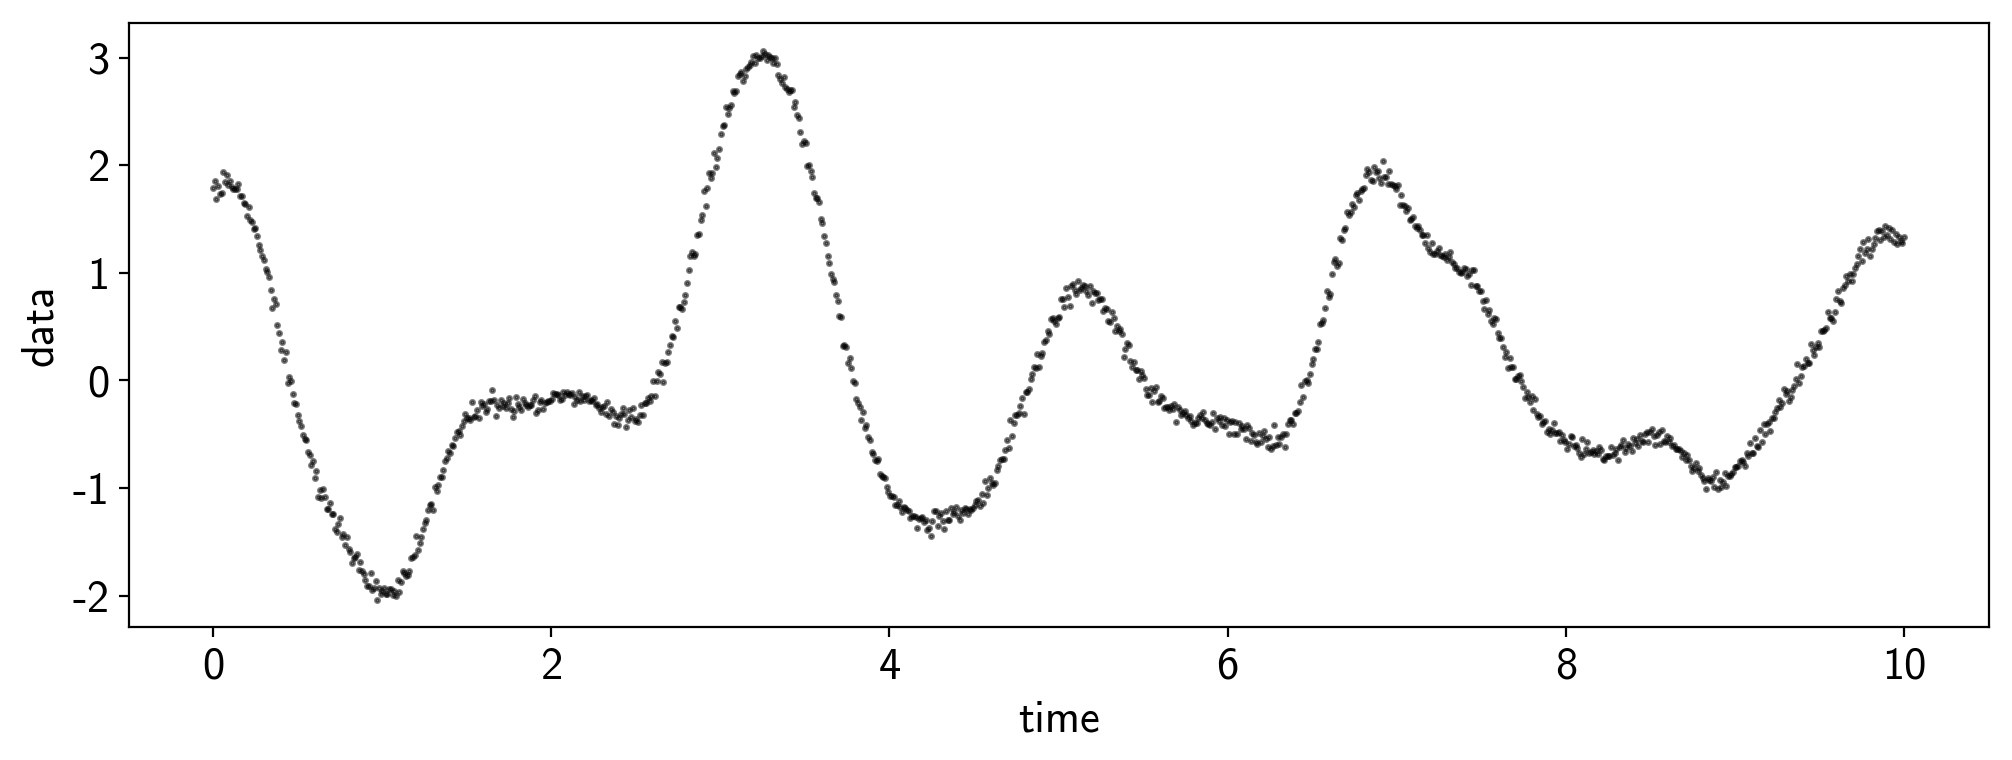

In [9]:
import matplotlib.pyplot as plt
t, y, sigma = np.loadtxt("data/sample_data.txt", unpack=True)
plt.plot(t, y, "k.", alpha=0.5, ms=3)
plt.xlabel("time")
plt.ylabel("data");

In [10]:
l = np.linspace(l_true - 0.1, l_true + 0.1, 300)
lnlike = np.array([ln_gp_likelihood(t, y, sigma=sigma, l=li) for li in l])

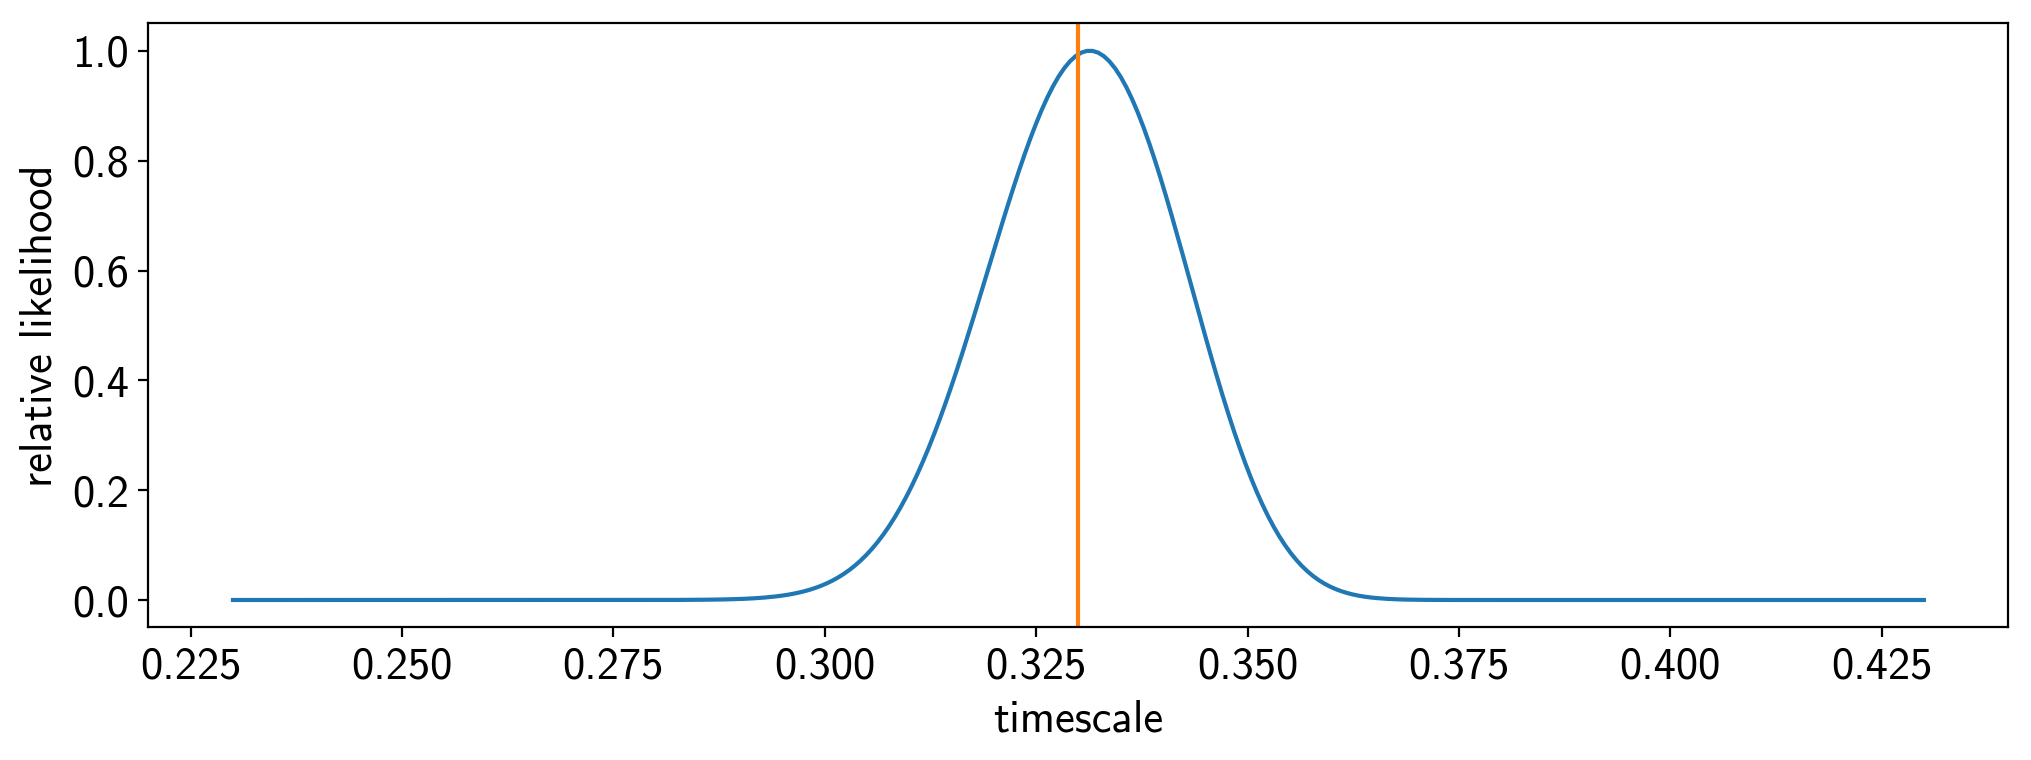

In [11]:
like = np.exp(lnlike - lnlike.max())
plt.plot(l, like)
plt.axvline(l_true, color="C1")
plt.xlabel("timescale")
plt.ylabel("relative likelihood");

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 3a</h1>
</div>

The timeseries below was generated by a linear function of time, $y(t)= mt + b$. In addition to observational uncertainty $\sigma$ (white noise), there is a fair bit of correlated (red) noise, which we will assume is well described
by the squared exponential covariance with a certain (unknown) amplitude $A$ and timescale $l$.

Your task is to estimate the values of $m$ and $b$, the slope and intercept of the line, respectively. In this part of the exercise, **assume there is no correlated noise.** Your model for the $n^\mathrm{th}$ datapoint is thus

$$
\begin{align}
    y_n \sim \mathcal{N}(m t_n + b, \sigma_n\mathbf{I})
\end{align}
$$

and the probability of the data given the model can be computed by calling your GP likelihood function:

```python
def lnprob(params):
    m, b = params
    model = m * t + b
    return ln_gp_likelihood(t, y - model, sigma, A=0, l=1)
```

Note, importantly, that we are passing the **residual vector**, $y - (mt + b)$, to the GP, since above we coded up a zero-mean Gaussian process. We are therefore using the GP to model the **residuals** of the data after applying our physical model (the equation of the line).

To estimate the values of $m$ and $b$ we could generate a fine grid in those two parameters and compute the likelihood at every point. But since we'll soon be fitting for four parameters (in the next part), we might as well upgrade our inference scheme and use the ``emcee`` package to do Markov Chain Monte Carlo (MCMC). If you haven't used ``emcee`` before, check out the first few tutorials on the [documentation page](https://emcee.readthedocs.io/en/latest/). The basic setup for the problem is this:

```python
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, nburn)   # nburn = 500 should do
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, nsteps);            # nsteps = 1000 should do
```

where ``nwalkers`` is the number of walkers (something like 20 or 30 is fine), ``ndim`` is the number of dimensions (2 in this case), and ``lnprob`` is the log-probability function for the data given the model. Finally, ``p0`` is a list of starting positions for each of the walkers. Pick some fiducial/eyeballed value for $m$ and $b$, then add a small random number to each to generate different initial positions for each walker. This will initialize all walkers in a ball centered on some point, and as the chain progresses they'll diffuse out and begin to explore the posterior.

Once you have sampled the posterior, plot several draws from it on top of the data. Also plot the **true** line that generated the dataset (given by the variables ``m_true`` and ``b_true`` below). Do they agree, or is there bias in your inferred values? Use the ``corner`` package to plot the joint posterior. How many standard deviations away from the truth are your inferred values?

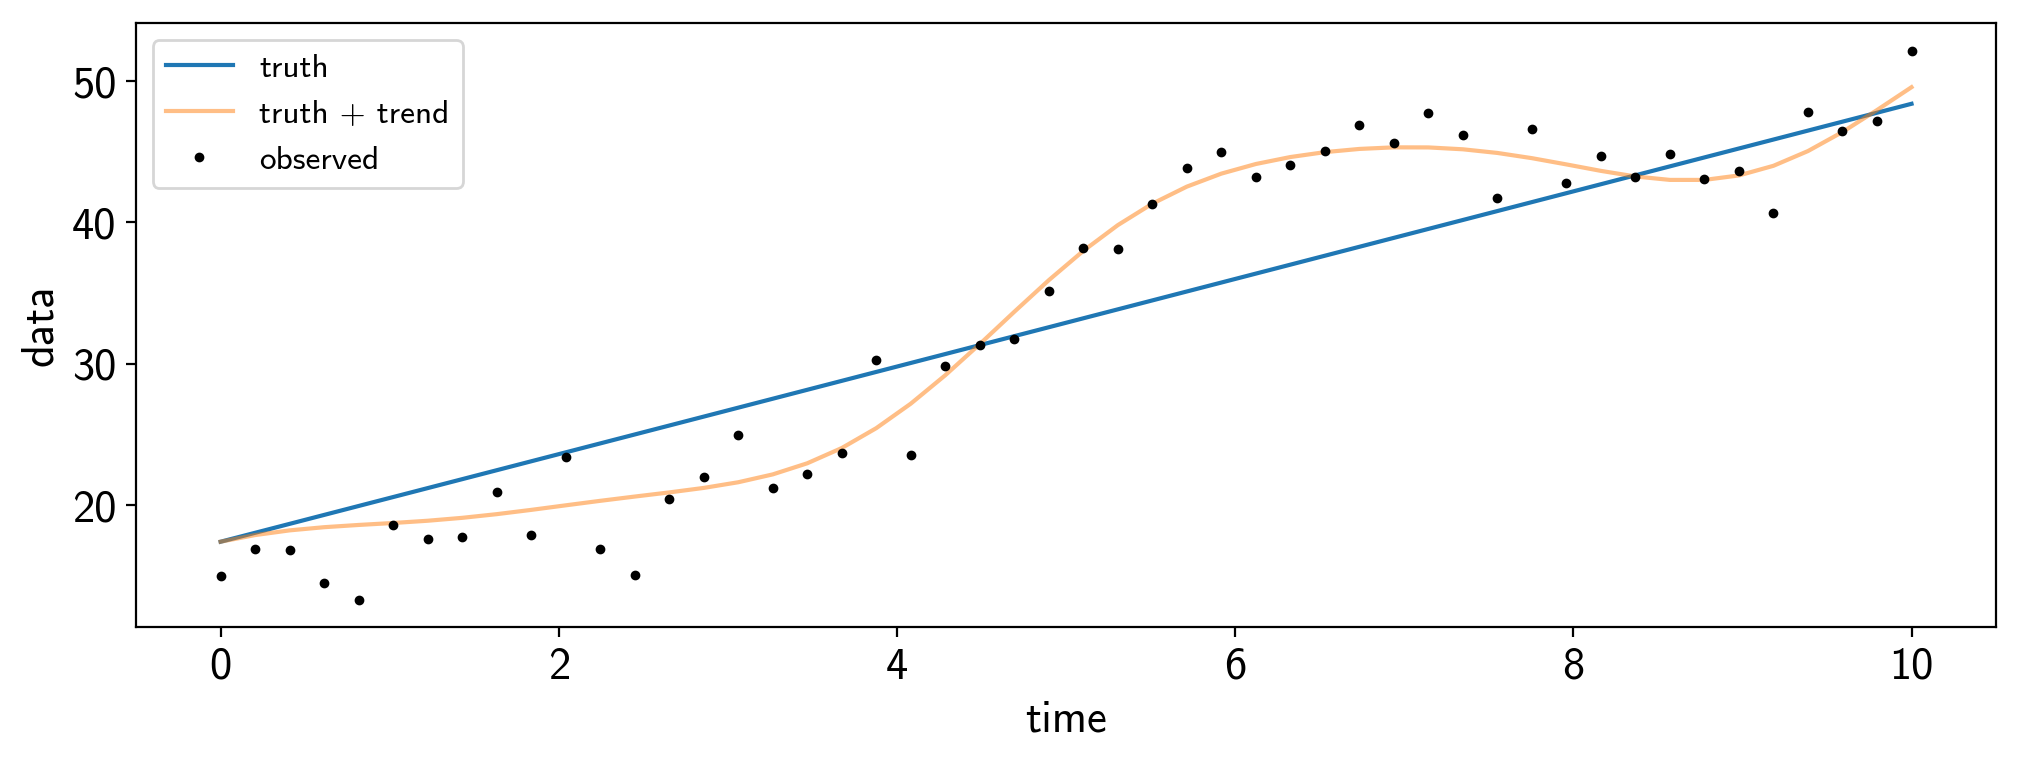

In [12]:
# Generate the data
m_true = 3.10
b_true = 17.4
l_true = 1.25
A_true = 3.50
s_true = 2.00
t = np.linspace(0, 10, 50)
gp_mu, gp_S = compute_gp([], [], t, A=A_true, l=l_true)
np.random.seed(9)
y_true = m_true * t + b_true
trend = draw_from_gaussian(gp_mu, gp_S)[0]
noise = np.ones_like(t) * s_true
y = y_true + trend + noise * np.random.randn(len(t))
X = np.hstack((t.reshape(-1, 1), y.reshape(-1, 1), noise.reshape(-1, 1)))
np.savetxt("data/sample_data_line.txt", X)
np.savetxt("data/sample_data_line_truths.txt", [m_true, b_true, A_true, l_true])

# Plot it
t, y, sigma = np.loadtxt("data/sample_data_line.txt", unpack=True)
plt.plot(t, y_true, "C0", label="truth")
plt.plot(t, y_true + trend, "C1", alpha=0.5, label="truth + trend")
plt.plot(t, y, "k.",  ms=5, label="observed")
plt.legend(fontsize=12)
plt.xlabel("time")
plt.ylabel("data");

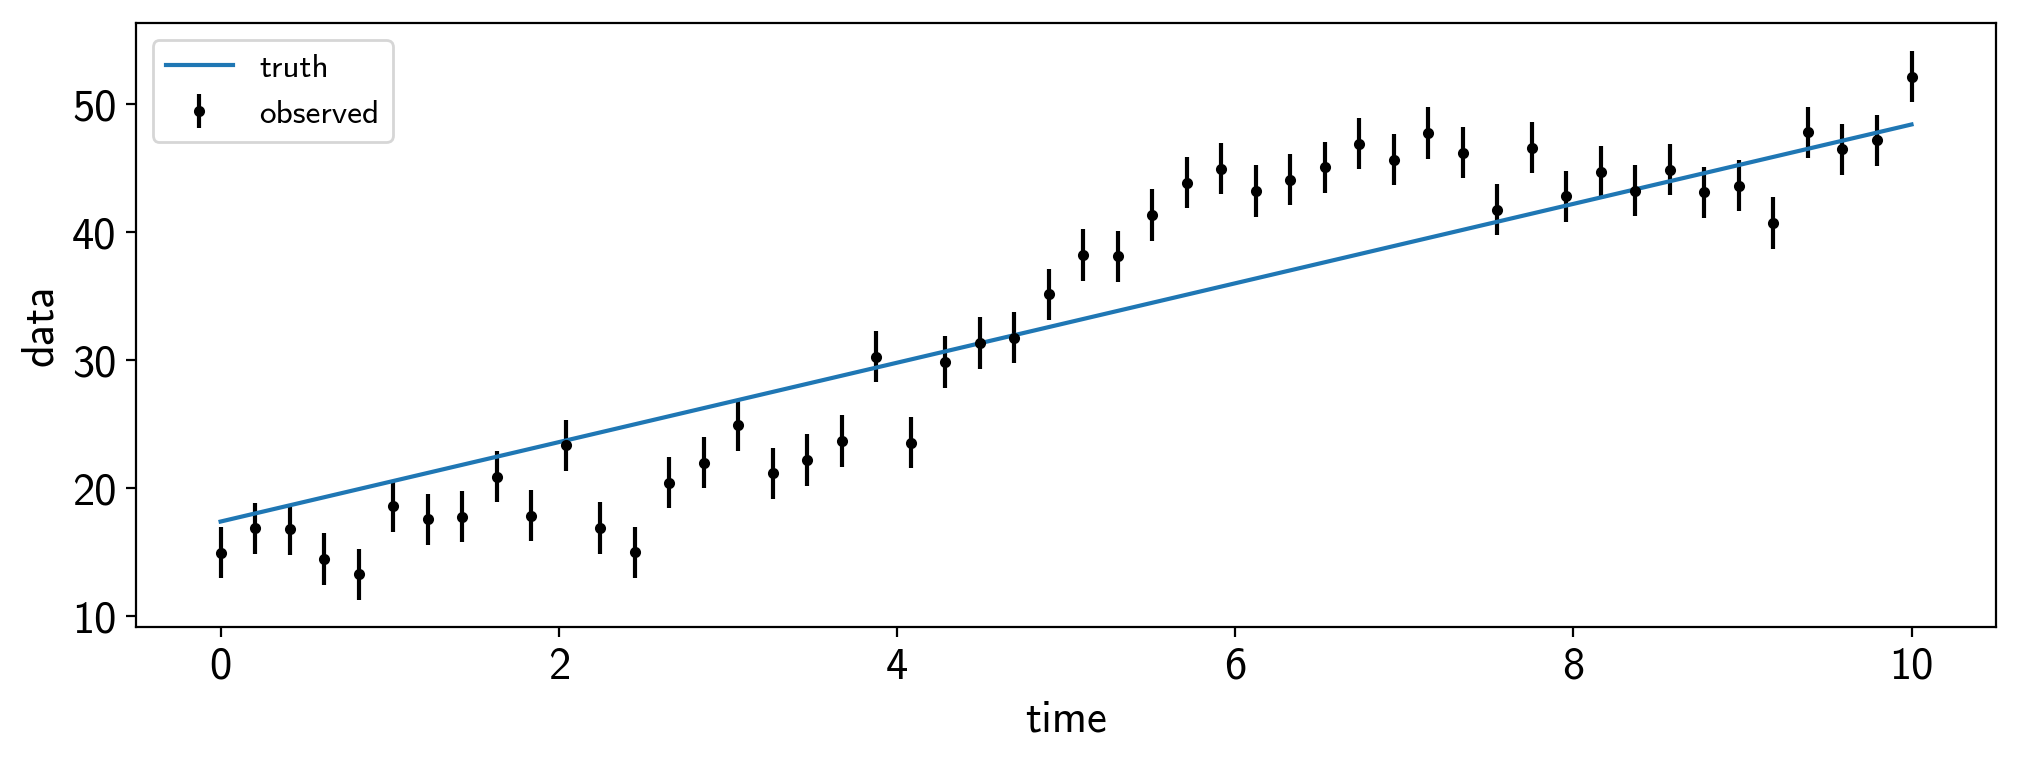

In [13]:
t, y, sigma = np.loadtxt("data/sample_data_line.txt", unpack=True)
m_true, b_true, A_true, l_true = np.loadtxt("data/sample_data_line_truths.txt", unpack=True)
plt.errorbar(t, y, yerr=sigma, fmt="k.", label="observed")
plt.plot(t, m_true * t + b_true, color="C0", label="truth")
plt.legend(fontsize=12)
plt.xlabel("time")
plt.ylabel("data");

In [14]:
def lnprob(p):
    """
    
    """
    m, b = p
    if (m < 0) or (m > 10):
        return -np.inf
    elif (b < 0) or (b > 30):
        return -np.inf
    model = m * t + b
    lnlike = ln_gp_likelihood(t, y - model, sigma, A=0, l=1)
    return lnlike

In [15]:
import emcee
print("Using emcee version {0}".format(emcee.__version__))

initial = [4.0, 15.0]
ndim = len(initial)
nwalkers = 32
p0 = initial + 1e-3 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 1000);

Using emcee version 2.2.1
Running burn-in...
Running production...


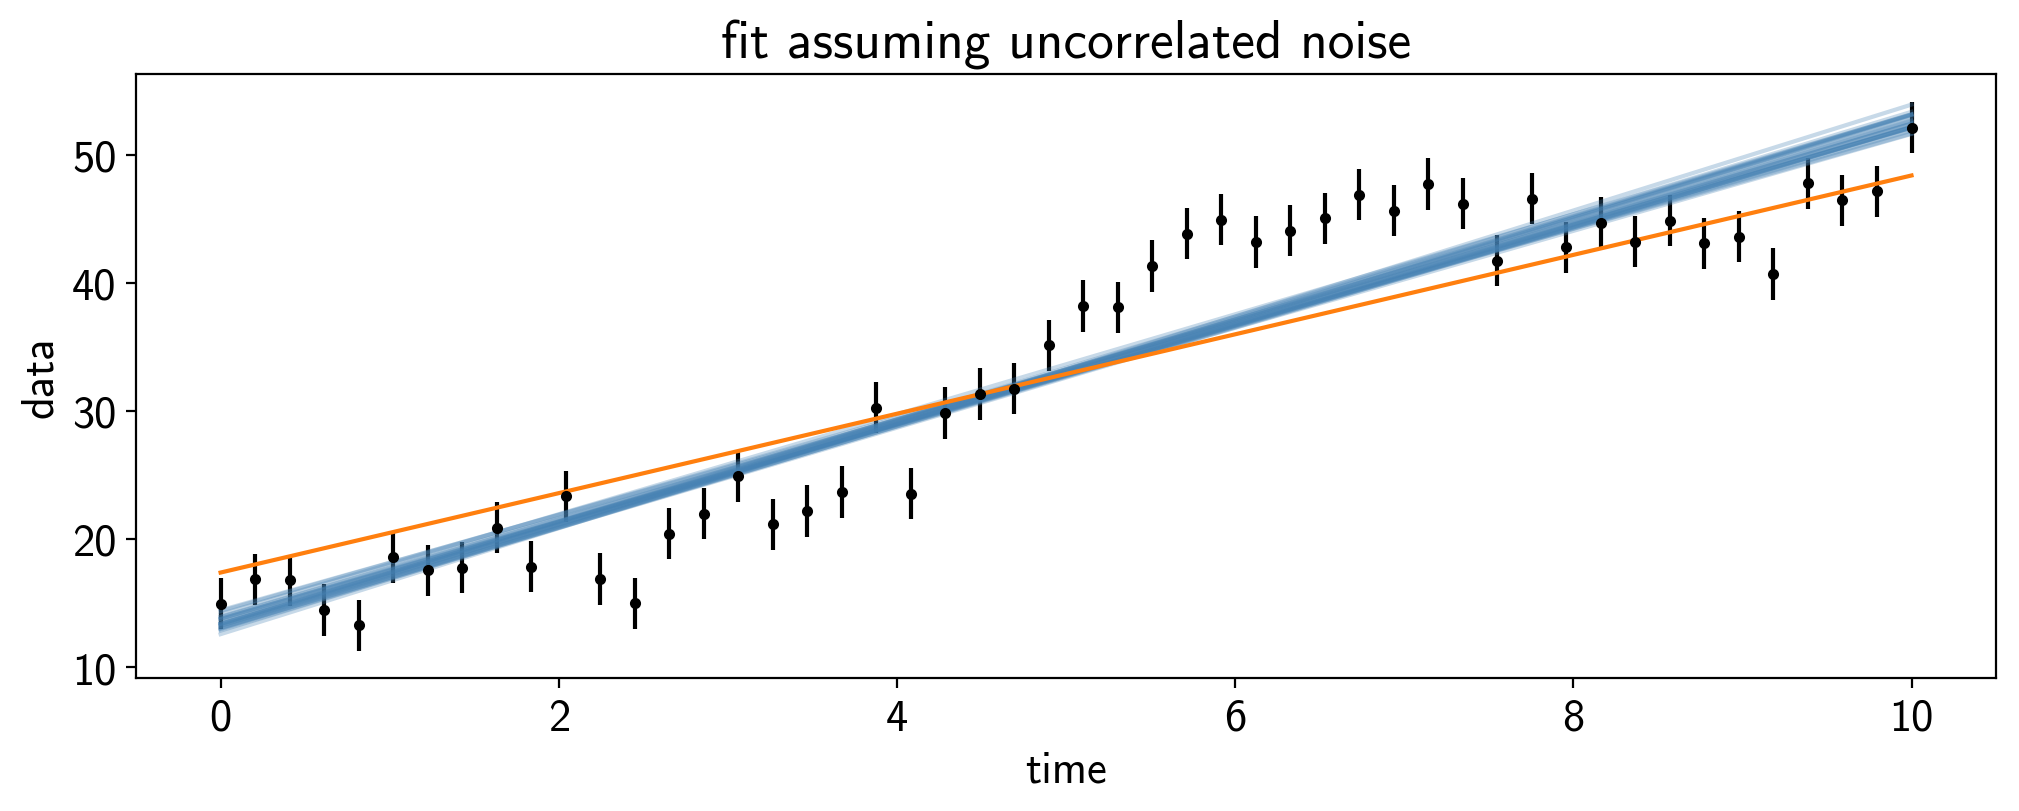

In [16]:
# Plot the data
plt.errorbar(t, y, yerr=sigma, fmt=".k", capsize=0)

# The positions where the prediction should be computed
x = np.linspace(0, 10, 500)

# Plot 24 posterior samples
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    m, b = s
    model = m * x + b
    plt.plot(x, model, color="#4682b4", alpha=0.3)

# Plot the truth
plt.plot(x, m_true * x + b_true, "C1", label="truth")
    
plt.ylabel("data")
plt.xlabel("time")
plt.title("fit assuming uncorrelated noise");

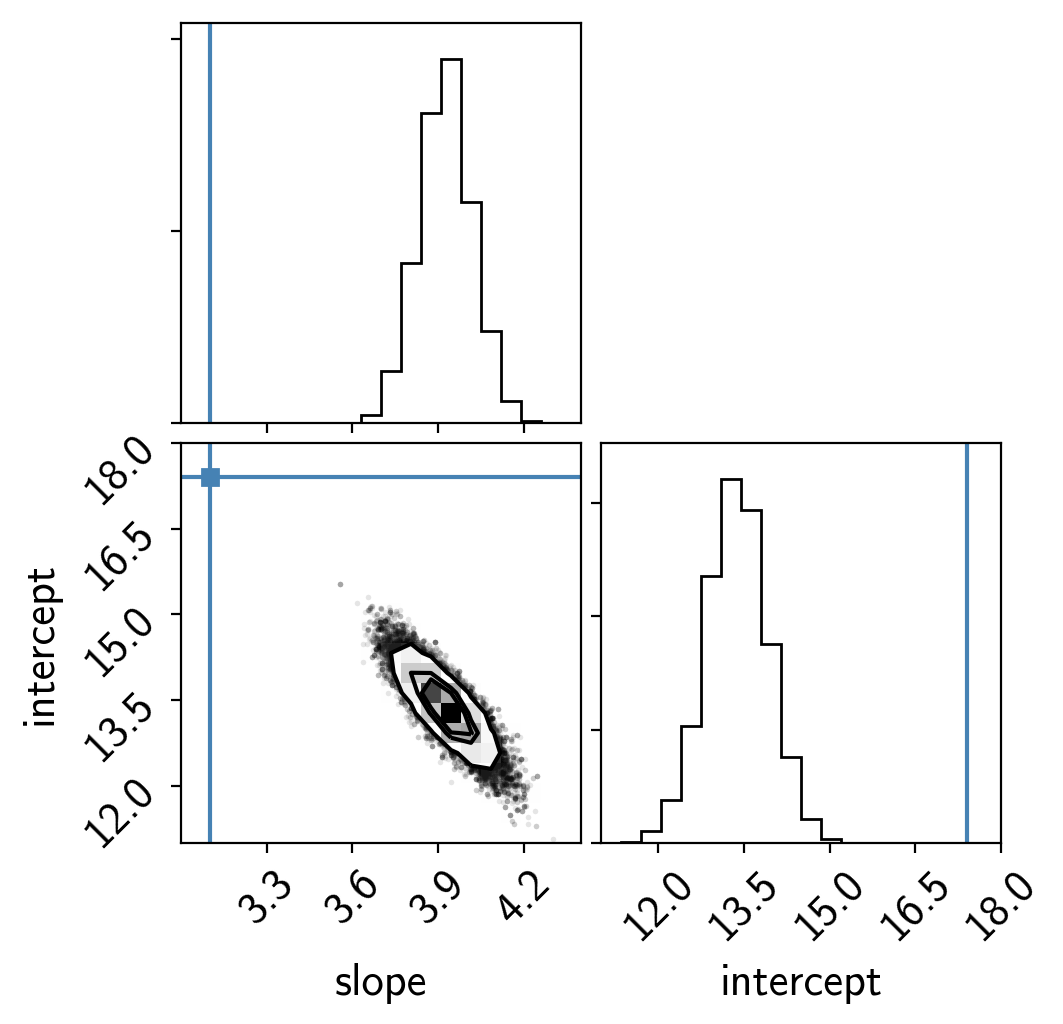

In [17]:
import corner
labels = ["slope", "intercept"]
truths = [m_true, b_true]
corner.corner(sampler.flatchain, truths=truths, labels=labels, range=[[3, 4.4], [11, 18]]);

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 3b</h1>
</div>

This time, let's actually model the correlated noise. Re-define your ``lnprob`` function to accept four parameters (slope, intercept, amplitude, and timescale). If you didn't before, it's a good idea to enforce some priors to keep the parameters within reasonable (and physical) ranges. If any parameter falls outside this range, have ``lnprob`` return negative infinity (i.e., zero probability).

You'll probably want to run your chains for a bit longer this time, too. As before, plot some posterior samples for the line, as well as the corner plot. How did you do this time? Is there any bias in your inferred values? How does the variance compare to the previous estimate?

In [18]:
def lnprob(p):
    """
    
    """
    m, b, A, l = p
    if (m < 0) or (m > 10):
        return -np.inf
    elif (b < 0) or (b > 30):
        return -np.inf
    elif (A < 0) or (A > 10):
        return -np.inf
    elif (l < 0) or (l > 10):
        return -np.inf
    model = m * t + b
    lnlike = ln_gp_likelihood(t, y - model, sigma, A=A, l=l)
    return lnlike

In [19]:
initial = [4.0, 15.0, 2.0, 1.0]
ndim = len(initial)
nwalkers = 32
p0 = initial + 1e-3 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 1500)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


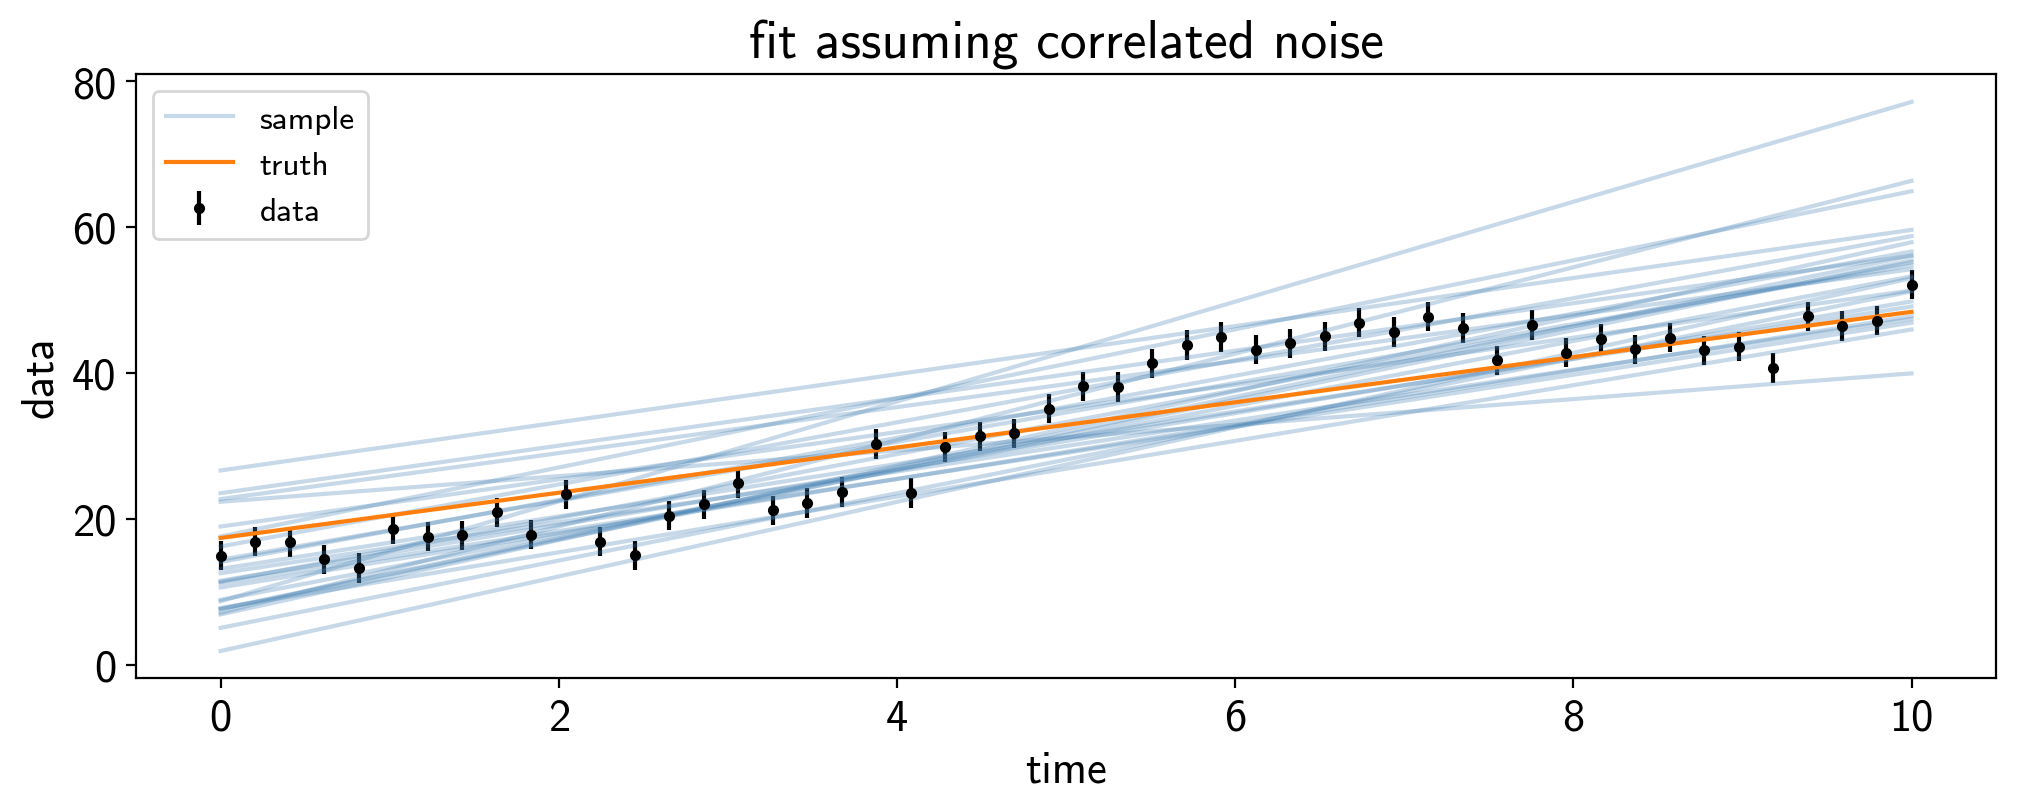

In [20]:
# Plot the data
plt.errorbar(t, y, yerr=sigma, fmt=".k", capsize=0, label="data")

# The positions where the prediction should be computed
x = np.linspace(0, 10, 500)

# Plot 24 posterior samples
samples = sampler.flatchain
label = "sample"
for s in samples[np.random.randint(len(samples), size=24)]:
    m, b, A, l = s
    model = m * x + b
    plt.plot(x, model, color="#4682b4", alpha=0.3, label=label)
    label = None

# Plot the truth
plt.plot(x, m_true * x + b_true, "C1", label="truth")
    
plt.ylabel("data")
plt.xlabel("time")
plt.legend(fontsize=12)
plt.title("fit assuming correlated noise");

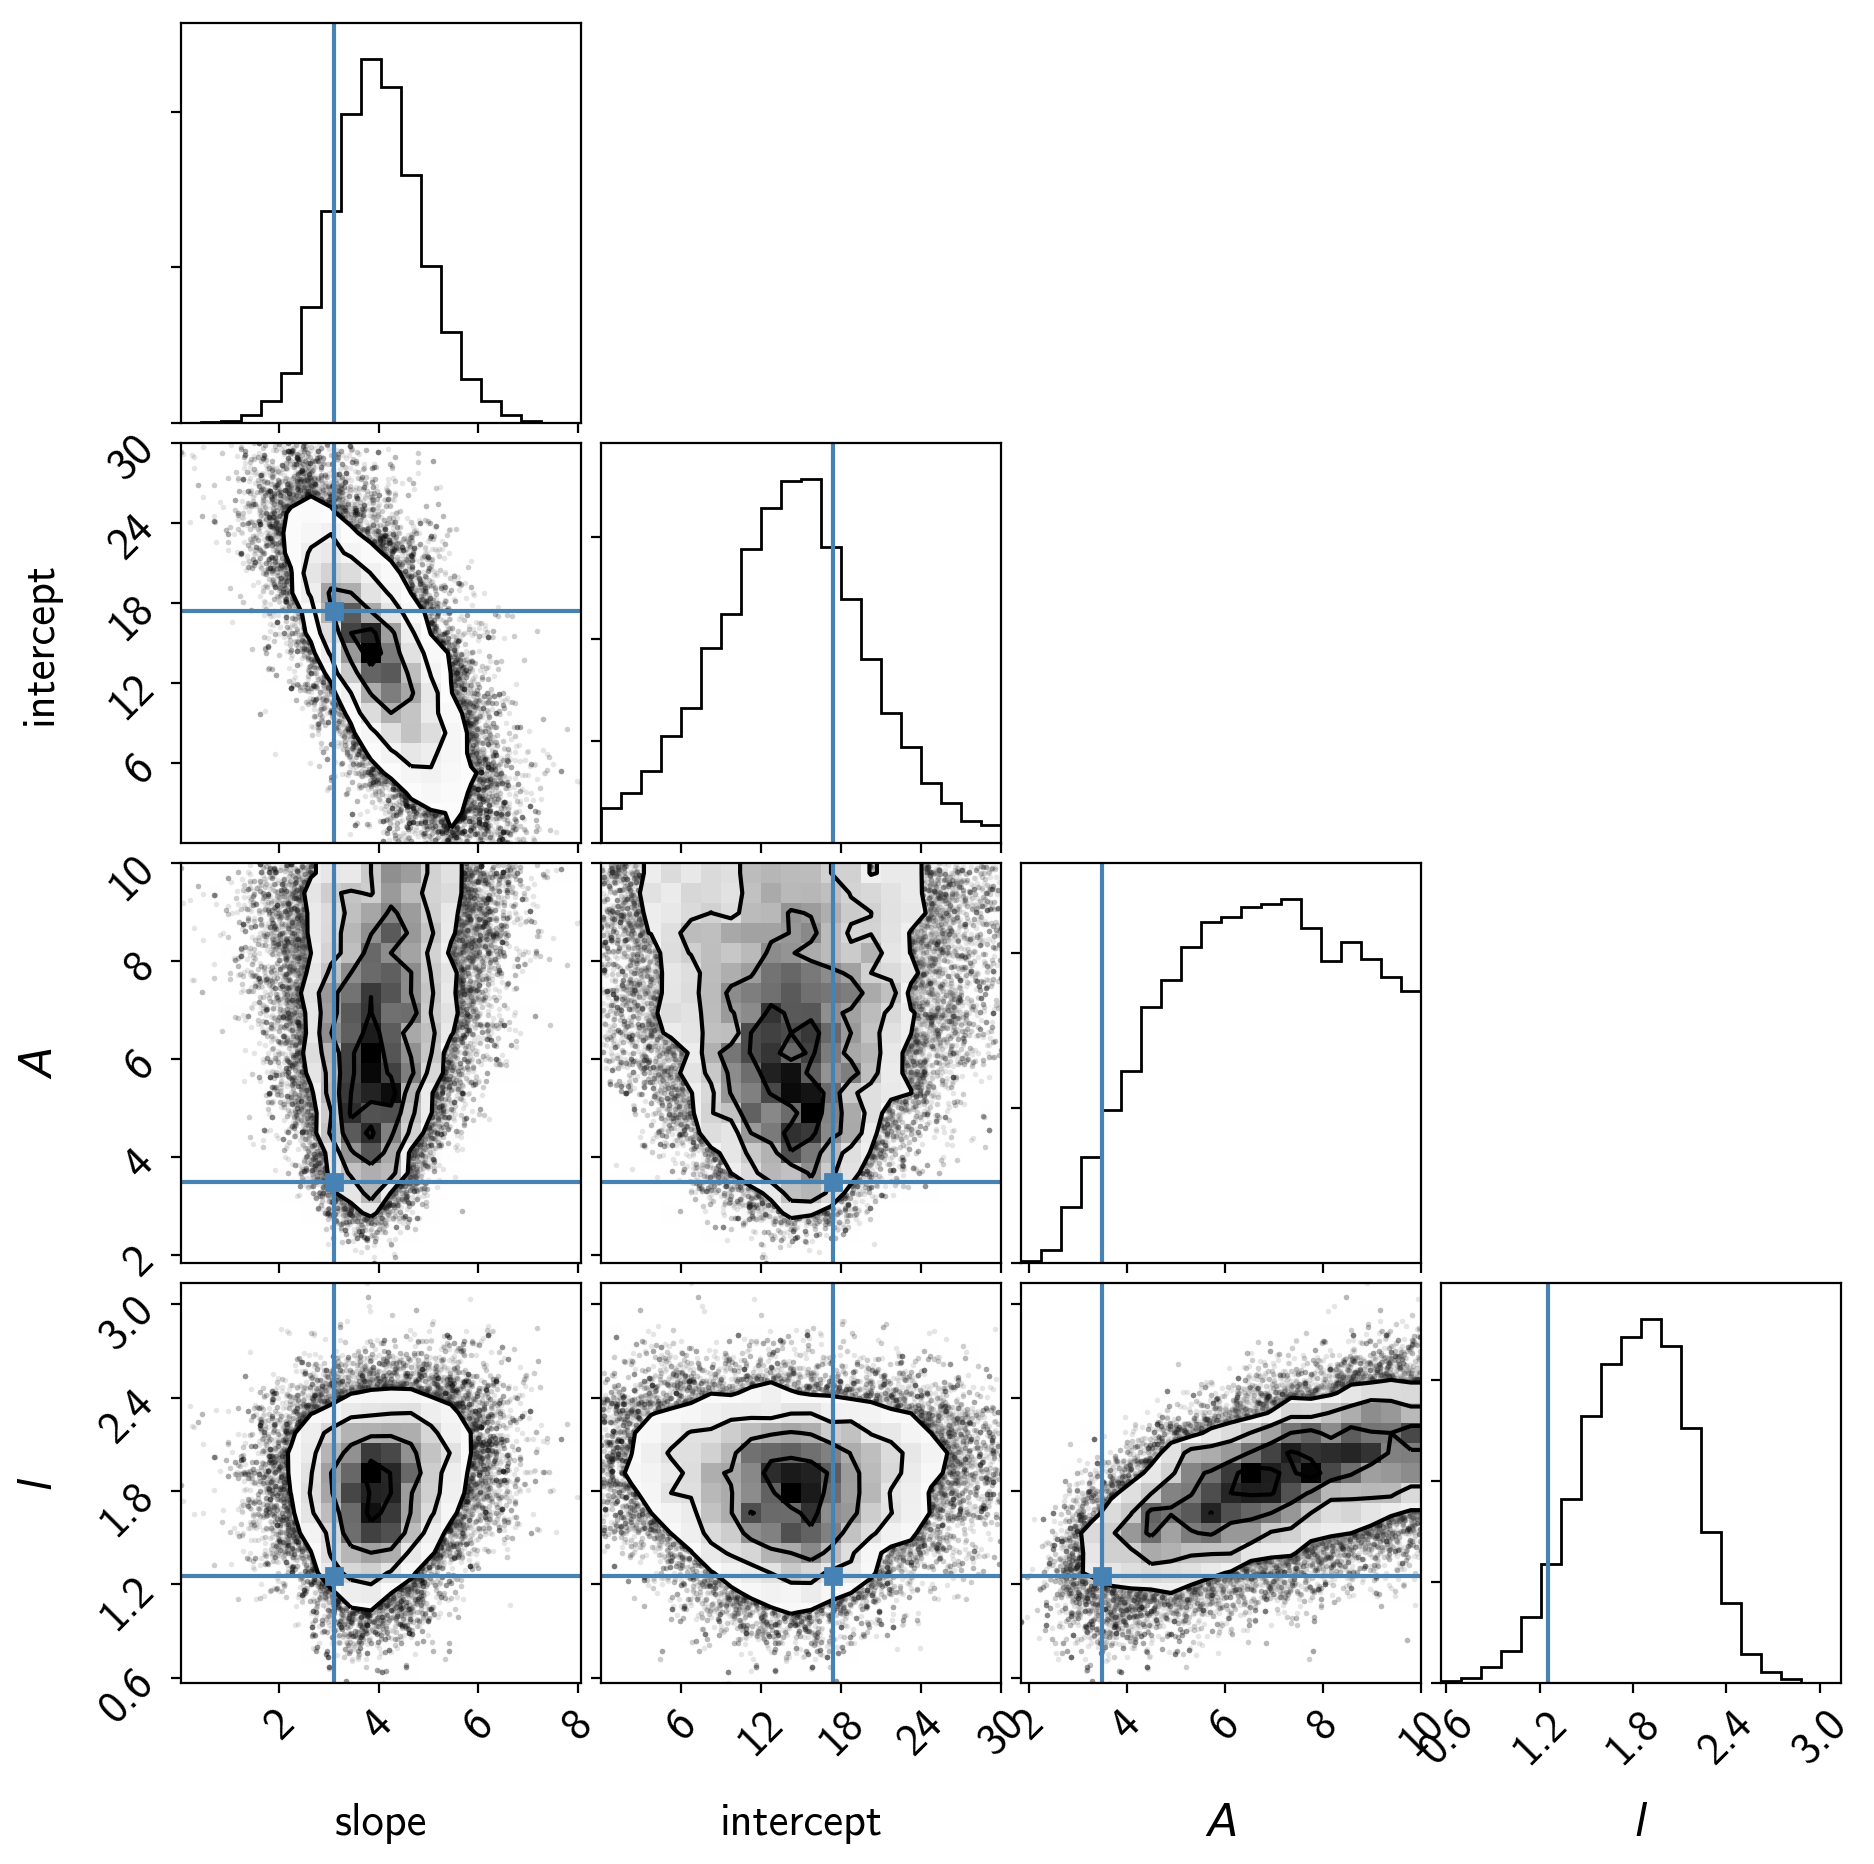

In [21]:
import corner
labels = ["slope", "intercept", r"$A$", r"$l$"]
truths = [m_true, b_true, A_true, l_true]
corner.corner(sampler.flatchain, truths=truths, labels=labels);

<div style="background-color: #D6EAF8; border-left: 15px solid #2E86C1;">
    <h1 style="line-height:2.5em; margin-left:1em;">Exercise 3c</h1>
</div>

If you didn't do this already, re-plot the posterior samples on top of the data, but this time draw them from the GP, *conditioned on the data*. How good is the fit?

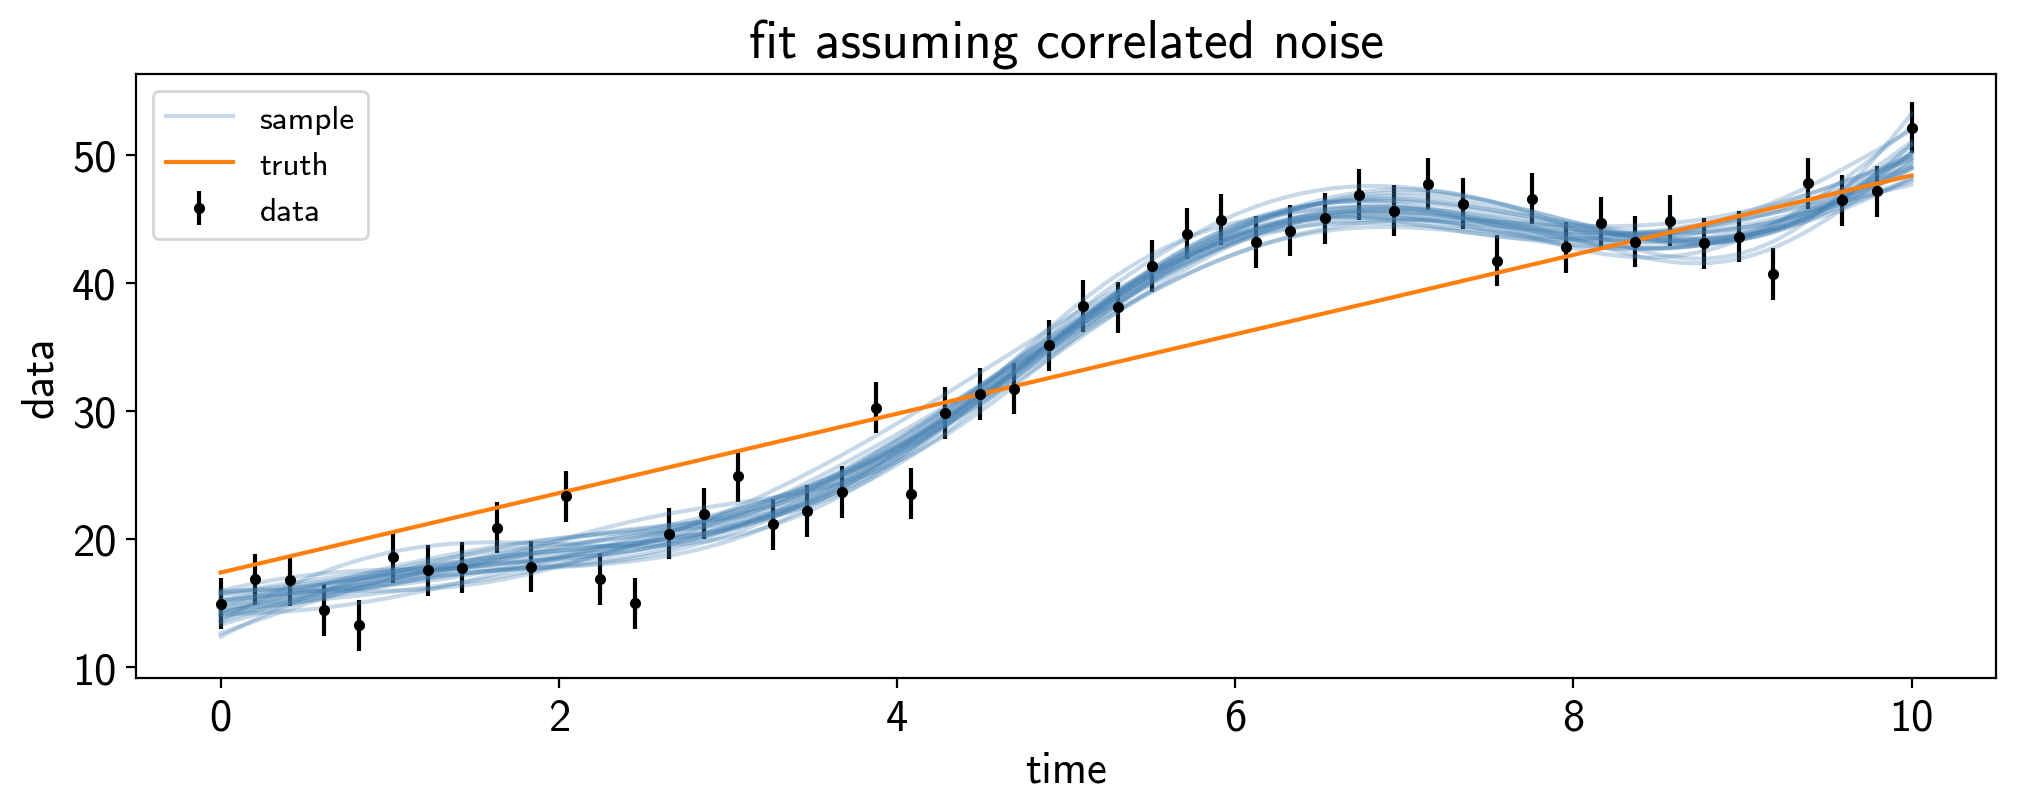

In [22]:
# Plot the data
plt.errorbar(t, y, yerr=sigma, fmt=".k", capsize=0, label="data")

# The positions where the prediction should be computed
x = np.linspace(0, 10, 500)

# Plot 24 posterior samples
samples = sampler.flatchain
label = "sample"
for s in samples[np.random.randint(len(samples), size=24)]:
    m, b, A, l = s
    model = m * x + b
    gp_mu, gp_S = compute_gp(t, y - (m * t + b), x, sigma=sigma, A=A, l=l)
    trend = draw_from_gaussian(gp_mu, gp_S)[0]
    plt.plot(x, model + trend, color="#4682b4", alpha=0.3, label=label)
    label = None

# Plot the truth
plt.plot(x, m_true * x + b_true, "C1", label="truth")
    
plt.ylabel("data")
plt.xlabel("time")
plt.legend(fontsize=12)
plt.title("fit assuming correlated noise");